In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=eea903a91c7a5b6cd0b2a7594cbb0c3c1661337b1efa2dc5086b68d8269141e4
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [3]:
import torchvision, time, os, copy
import torch.nn as nn
import torch.optim as optim
import torch, json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import cv2 as cv
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
from albumentations import ShiftScaleRotate
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve
from sklearn.metrics import log_loss
from tqdm import tqdm_notebook as tqdm
from efficientnet_pytorch import EfficientNet

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        #transforms.ColorJitter(brightness = 0.5),
        transforms.Resize((224,224)),
        #transforms.CenterCrop(150),
        transforms.ToTensor(), 
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}


TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [4]:
train_image_datasets = datasets.ImageFolder(TRAINING_DATA_FOLDER, data_transforms['train'])
test_image_datasets = datasets.ImageFolder(TESTING_DATA_FOLDER, data_transforms['test'])

In [5]:
# Creating data indices for training and validation splits:
dataset_size = len(train_image_datasets)

indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(322)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
print(dataset_size)

2183


In [6]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True)
dataloaders = {'train': train_loader,'val':validation_loader}
dataset_sizes = {'train':len(train_loader.sampler),'val':len(validation_loader.sampler)}
class_names = train_image_datasets.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
torch.cuda.is_available()

True

In [8]:
# Helper function for displaying images
def imshow(images, title=None):
    # Clip just in case
    images = np.clip(images.permute(1, 2, 0), 0, 1)
    plt.imshow(images)
    plt.pause(0.001)  # pause a bit so that plots are updated

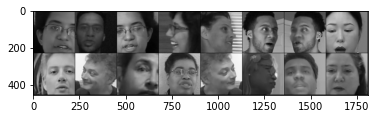

In [9]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
grid = torchvision.utils.make_grid(inputs)

imshow(grid)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),total=len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1).type(torch.cuda.FloatTensor))
                    preds = torch.round(torch.sigmoid(outputs))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            scheduler.step()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [11]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)
# Set the loss function
criterion = nn.BCEWithLogitsLoss()

# Observe that only the parameters of the final layer are being optimized
optimizer_conv = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0
Epoch 1/10
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.6081 Acc: 0.6703



val Loss: 0.7030 Acc: 0.4977

Epoch 2/10
----------



train Loss: 0.4342 Acc: 0.8168



val Loss: 0.7439 Acc: 0.4885

Epoch 3/10
----------



train Loss: 0.3283 Acc: 0.8592



val Loss: 0.7131 Acc: 0.5849

Epoch 4/10
----------



train Loss: 0.2336 Acc: 0.9078



val Loss: 0.5401 Acc: 0.7317

Epoch 5/10
----------



train Loss: 0.1954 Acc: 0.9302



val Loss: 0.4076 Acc: 0.8188

Epoch 6/10
----------



train Loss: 0.1682 Acc: 0.9382



val Loss: 0.4287 Acc: 0.8165

Epoch 7/10
----------



train Loss: 0.1521 Acc: 0.9513



val Loss: 0.3706 Acc: 0.8394

Epoch 8/10
----------



train Loss: 0.1448 Acc: 0.9485



val Loss: 0.3317 Acc: 0.8578

Epoch 9/10
----------



train Loss: 0.1498 Acc: 0.9450



val Loss: 0.3026 Acc: 0.8624

Epoch 10/10
----------



train Loss: 0.1566 Acc: 0.9433



val Loss: 0.3008 Acc: 0.8670

Training complete in 21m 4s
Best val Acc: 0.866972


In [12]:
predictions = []
testlabels = []
predictions_class = []
for idx, (inputs, labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = model(inputs)
  preds = torch.sigmoid(outputs)
  preds_class = torch.round(preds)
  testlabels.extend(labels.cpu().detach().numpy())
  predictions.extend(preds.cpu().detach().numpy())
  predictions_class.extend(preds_class.cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [13]:
f1_score(testlabels, predictions_class, average="macro")

0.8412298387096775

In [14]:
log_loss(testlabels,predictions)

0.3786065168338061